<a href="https://colab.research.google.com/github/navinor/dl-survey-live-lab-2025/blob/main/notebooks/01_baseline_support_vector_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01 — Baseline Random Forest (Student)

**Today we will:**
1) Load the Adult dataset (classification: `income`).
2) Split train/test **first** (avoid leakage).
3) Handle missing values (numeric: mean; categorical: most frequent).
4) Encode categorical features:
   - Label encode **one** column (`sex`)
   - One-hot encode the rest
5) (Practice) Scale numeric features (StandardScaler).
6) Train a **RandomForestClassifier** and evaluate it.
7) **Deep dive** into the RF object: attributes & methods.
8) Try a few hyperparameters and record results in your `students/experiment_log.md`.
9) Peek at **GridSearchCV** (teacher-led demo).

> As you work: add short notes in your experiment log (Goal → Setup → Results → Reflection).


### Setup

In [17]:
# 0) Setup
!pip -q install scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_openml
from sklearn import preprocessing # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay # creates and draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

print("Ready.")


Ready.


### Load data

In [9]:
# 1) Load the Adult dataset from OpenML
adult = fetch_openml(name="adult", version=2, as_frame=True)
df = adult.frame.copy()
df.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


**Question:** Is this a classification or regression problem?  
**Target column:** ???


### Choose columns & split FIRST

In [10]:
# 2) Choose columns (keep it small for speed)
numeric_features = ["age", "hours-per-week", "education-num", "capital-gain", "capital-loss"]
categorical_features = ["workclass", "marital-status", "occupation", "sex", "native-country"]
target_col = "class"

use_cols = numeric_features + categorical_features + [target_col]
df = df[use_cols].copy()

# 3) Split FIRST (to avoid leakage)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((39073, 10), (9769, 10))

**Why split first?**  
So that ....


### Handle missing values

In [11]:
# 4) Impute missing values
# Numeric → mean (try median later if you like)
num_imputer = SimpleImputer(strategy="mean")
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_features]),
                           columns=numeric_features, index=X_train.index)
X_test_num  = pd.DataFrame(num_imputer.transform(X_test[numeric_features]),
                           columns=numeric_features, index=X_test.index)

# Categorical → most frequent
cat_imputer = SimpleImputer(strategy="most_frequent")
X_train_cat_raw = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_features]),
                               columns=categorical_features, index=X_train.index)
X_test_cat_raw  = pd.DataFrame(cat_imputer.transform(X_test[categorical_features]),
                               columns=categorical_features, index=X_test.index)


### Encode categoricals

In [12]:
# 5) Encode categoricals
# Label-encode ONE column ('sex'); one-hot the rest
label_encode_col = "sex"

# Copies
X_train_processed = X_train_cat_raw.copy()
X_test_processed  = X_test_cat_raw.copy()

# LabelEncoder: fit on train, apply to test
le = LabelEncoder()
X_train_processed[label_encode_col] = le.fit_transform(X_train_processed[label_encode_col])
X_test_processed[label_encode_col]  = le.transform(X_test_processed[label_encode_col])

# One-hot all other categorical columns
onehot_cols = [c for c in X_train_processed.columns if c != label_encode_col]

# Version-safe: sparse_output (>=1.2) vs sparse (<1.2)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

X_train_ohe_array = ohe.fit_transform(X_train_processed[onehot_cols])
X_test_ohe_array  = ohe.transform(X_test_processed[onehot_cols])

ohe_feature_names = ohe.get_feature_names_out(onehot_cols)
X_train_ohe = pd.DataFrame(X_train_ohe_array, columns=ohe_feature_names)
X_test_ohe  = pd.DataFrame(X_test_ohe_array,  columns=ohe_feature_names)

# Combine label-encoded + one-hot (reset indices for alignment)
label_encoded_train = X_train_processed[[label_encode_col]].reset_index(drop=True)
label_encoded_test  = X_test_processed[[label_encode_col]].reset_index(drop=True)
X_train_cat = pd.concat([label_encoded_train, X_train_ohe.reset_index(drop=True)], axis=1)
X_test_cat  = pd.concat([label_encoded_test,  X_test_ohe.reset_index(drop=True)],  axis=1)

X_train_cat.shape, X_test_cat.shape


((39073, 71), (9769, 71))

In [26]:
y_test

,class
40342,<=50K
47680,<=50K
524,<=50K
8508,<=50K
31692,>50K
...,...
20384,<=50K
28000,<=50K
22163,>50K
24733,<=50K


**Reflect:**  
- When might **label encoding** be risky?  
- Why is **one-hot** often safer for models like Logistic Regression or Neural Nets?


### Scale numeric features (practice)

In [21]:
# 6) Scale numeric features (practice—even if RF doesn’t need it)
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(scaler.fit_transform(X_train_num), columns=numeric_features)
X_test_num_scaled  = pd.DataFrame(scaler.transform(X_test_num),   columns=numeric_features)

# Assemble final matrices (reset indices to align rows)
X_train_final = pd.concat([X_train_num_scaled.reset_index(drop=True),
                           X_train_cat.reset_index(drop=True)], axis=1)
X_test_final  = pd.concat([X_test_num_scaled.reset_index(drop=True),
                           X_test_cat.reset_index(drop=True)],  axis=1)

X_train_final.shape, X_test_final.shape


((39073, 76), (9769, 76))

**When would you prefer**:
- `MinMaxScaler` ?
- `RobustScaler` ?


# Support Vector Machine

In [18]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_final, y_train)

SVC(random_state=42)

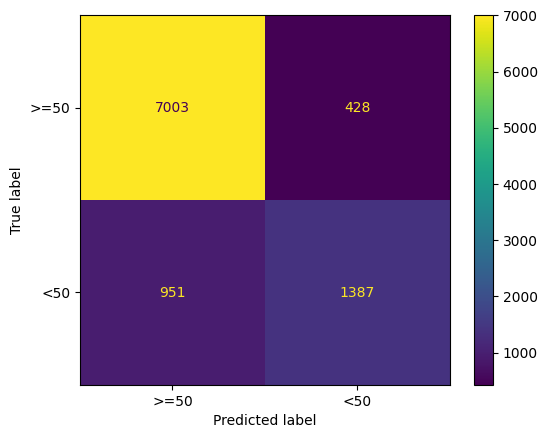

In [28]:
ConfusionMatrixDisplay.from_estimator(clf_svm,
                                      X_test_final,
                                      y_test,
                                      values_format='d',
                                      display_labels=[">=50", "<50"])

In [ ]:
param_grid = [
  {'C': [0.5, 1, 10, 100], # NOTE: Values for C must be > 0
   'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
   'kernel': ['rbf']},
]
## NOTE: We are includeing C=1 and gamma='scale'
## as possible choices since they are the default values.

optimal_params = GridSearchCV(
        SVC(),
        param_grid,
        cv=5,
        scoring='accuracy', ## (accruacy is default scoring) Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='balanced_accuracy', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1', ## Terrible!!! C=0.5, gamma=1
        ##scoring='f1_micro', ## Slightly improved, but hardly!!! C=1, gamma=0.01
        ##scoring='f1_macro', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='f1_weighted', ## Same!! C=1, gamma='scale' (these are the same as default values)
        ##scoring='roc_auc', ## Terrible!!! C=1, gamma=0.001
        ## For more scoring metics see:
        ## https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        verbose=0 # NOTE: If you want to see what Grid Search is doing, set verbose=2
    )

optimal_params.fit(X_train_final, y_train)
print(optimal_params.best_params_)

In [ ]:
clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_final, y_train)

### Saving Model Objects to a Pickle File

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # Mount your drive

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#change directory to where you want the model to be saved in your drive
%cd /content/drive/MyDrive/ADS2_Aaron/

In [ ]:
import pickle

print("SAVING COMPLETE MODEL PACKAGE")
print("=" * 50)

# Create a complete model package
model_package = {
    'model': rf,
    'preprocessors': {
        'num_imputer': num_imputer,
        'scaler': scaler,
        'cat_imputer': cat_imputer,
        'label_encoder': le,
        'onehot_encoder': ohe
    },
    'data': {
        'X_train': X_train_final,
        'X_test': X_test_final,
        'y_train': y_train,
        'y_test': y_test
    }
}


with open('model_package.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Saved: model_package.pkl")